### Presentation #3: Bright Daniel, Kurt Vetter, Hunter Merriman

In this version the following two datasets were merged based on Year and Country:

https://ourworldindata.org/grapher/states-involved-in-state-based-conflicts?tab=table&time=1986..latest#sources-and-processing

Maternal Mortality.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

# ------------------------------
# 1. Load the dataset
# ------------------------------
#input_filename = 'mm_updated_dataset.csv'
input_filename = 'mm_conflicts_merged.csv'           # updated merged file

df = pd.read_csv(input_filename)



In [ ]:
df.to_csv('mm_updated_NN_dataset.csv', index=False)
print("Updated dataset saved to mm_updated_NN_dataset.csv")

Updated dataset saved to mm_updated_NN_dataset.csv


Use re-merged files provided by Bright "unique_mm.csv"

In [ ]:
# Load the  re-merged dataset
input_filename = 'mm_updated_NN_dataset.csv'
df = pd.read_csv(input_filename)

# Encode the 'Country' column using the provided label encoder
df['Country_enc'] = country_le.fit_transform(df['Country'])

# Select the numeric features for analysis.
feature_cols = ['Country_enc', 'Mortality Rate', 'At War']
data = df[feature_cols].values

# Scale features to [0, 1] to help training the neural network.
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)        # based on Brights re-merged dataset

Implement Autoencoder Neural Network

In [ ]:
# ------------------------------
# 6. Build and train an autoencoder for feature extraction
# ------------------------------
# We choose a low-dimensional (here 2 neurons) latent space so that we can later study how these new features relate to the original ones.
input_dim = data_scaled.shape[1]
encoding_dim = 2  # the size of our bottleneck layer

# Define the autoencoder architecture.
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model to extract latent features
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the model using mean squared error loss.
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder.
# (For demonstration, the number of epochs is modest. For better performance, you might increase epochs and adjust batch size.)
autoencoder.fit(data_scaled, data_scaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                verbose=1)

# ------------------------------
# 7. Extract the latent features using the encoder
# ------------------------------
encoded_features = encoder.predict(data_scaled)
encoded_df = pd.DataFrame(encoded_features, columns=['encoded_feature_1', 'encoded_feature_2'])

# Concatenate the new features with the original DataFrame.
df = pd.concat([df, encoded_df], axis=1)

# ------------------------------
# 8. Quantify the feature relationships
# ------------------------------
# Here, we compute the correlation matrix among the encoded features and the key original features,
# namely Country_enc, Mortality_Rate, GDP, and At War_enc.
#cols_to_correlate = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'encoded_feature_1', 'encoded_feature_2']
cols_to_correlate = ['Country_enc', 'Mortality Rate','At War']   # based on Brights re-merged dataset

corr_matrix = df[cols_to_correlate].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Optionally, if you want to inspect the correlations related only to the original features:
original_corr = df[['Country_enc', 'Mortality Rate', 'At War']].corr()
print("\nOriginal Feature Correlation Matrix:")
print(original_corr)


Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.1506
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.1038
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0641
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0388
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0259
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0187
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0142
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0107
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.0088
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 0.0074
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.0064
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.0056
Epoch 13/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0053
Epoch 14/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0049
Epoch 15/50
352/352 ━━━━━━━━━

Plotting the Correlation Matrix:
The code creates a heatmap of the correlation matrix using plt.imshow(), setting up the color map as 'coolwarm' and labeling both x- and y-axes with feature names. The color bar visually represents the strength of the correlations.

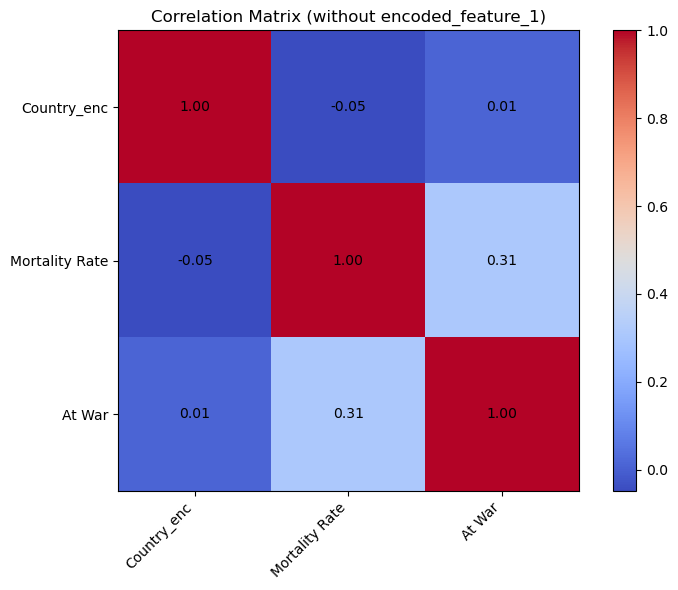

In [ ]:
import matplotlib.pyplot as plt
# Remove 'encoded_feature_1' from the correlation matrix
#corr_plot = corr_matrix.drop(index='encoded_feature_1', columns=['encoded_feature_1'])

corr_plot = corr_matrix.drop(index='encoded_feature_1', columns=['encoded_feature_1'], errors='ignore')   #

# Plot the reduced correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_plot, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

# Set ticks and labels
ticks = np.arange(len(corr_plot.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_plot.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_plot.index)

# Annotate each cell with the correlation value
for i in range(corr_plot.shape[0]):
    for j in range(corr_plot.shape[1]):
        ax.text(j, i, f"{corr_plot.iloc[i, j]:.2f}", ha="center", va="center", color="black")

ax.set_title("Correlation Matrix (without encoded_feature_1)")
plt.tight_layout()
plt.show()

In [ ]:
print(encoded_df['encoded_feature_1'].describe())
print(encoded_df['encoded_feature_2'].describe())

count    5625.000000
mean        2.243711
std         0.855370
min         0.712956
25%         1.567874
50%         2.224577
75%         2.875463
max         4.476758
Name: encoded_feature_1, dtype: float64
count    5625.000000
mean        0.778928
std         0.962793
min         0.000000
25%         0.103403
50%         0.461356
75%         0.788846
max         5.612698
Name: encoded_feature_2, dtype: float64


Let's try optimizing the Autoencoder

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_autoencoder(encoding_dim=2, optimizer='adam'):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder
model = KerasRegressor(model=build_autoencoder, verbose=0)
param_grid = {
    'model__encoding_dim': [2, 4, 8],
    'model__optimizer': ['adam', 'sgd'],
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

# Perform grid search to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(data_scaled, data_scaled)

print(f"Best parameters: {grid_result.best_params_}")


Best parameters: {'batch_size': 32, 'epochs': 100, 'model__encoding_dim': 8, 'model__optimizer': 'adam'}


In [ ]:
from tensorflow.keras.models import Model

# Get the best estimator's model from grid search
best_model = grid_result.best_estimator_.model_

# Create an encoder model that outputs the bottleneck layer
encoder_best = Model(inputs=best_model.input, outputs=best_model.layers[1].output)

# Predict the latent features using the best autoencoder
encoded_features_best = encoder_best.predict(data_scaled)
n_features = encoded_features_best.shape[1]
column_names = [f'best_encoded_feature_{i+1}' for i in range(n_features)]
encoded_df_best = pd.DataFrame(encoded_features_best, columns=column_names)

# Add the new features to a copy of the original DataFrame for correlation analysis
df_best = df.copy()
if 'Country_enc' not in df_best.columns:
    df_best['Country_enc'] = country_le.transform(df_best['Country'])
if 'At War_enc' not in df_best.columns:
    df_best['At War_enc'] = df_best['At War'].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'at war', 'true'] else 0)
df_best[column_names] = encoded_df_best

# Create correlation matrix using original features and the new latent features
#cols = ['Country_enc', 'Mortality Rate', 'GDP', 'At War_enc', 'best_encoded_feature_1', 'best_encoded_feature_2'] # based on Brights re-merged dataset
cols = ['Country_enc', 'Mortality Rate', 'At War_enc', 'best_encoded_feature_1', 'best_encoded_feature_2']
corr_matrix_best = df_best[cols].corr()



176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


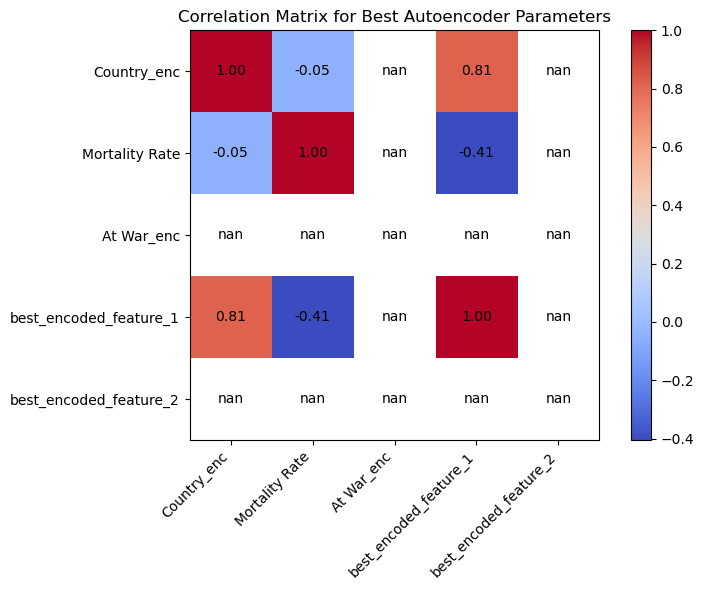

In [ ]:
# Plot the correlation matrix heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix_best, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(len(corr_matrix_best.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix_best.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix_best.index)

# Annotate each cell with the correlation value
for i in range(corr_matrix_best.shape[0]):
    for j in range(corr_matrix_best.shape[1]):
        ax.text(j, i, f"{corr_matrix_best.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix for Best Autoencoder Parameters")
plt.tight_layout()
plt.show()

Try additional Autoencoder optimzation of number of hidden layers and activation function.

In [ ]:

from tensorflow.keras.layers import Input, Dense, LeakyReLU
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler

# Assuming data_scaled is your input data
input_dim = data_scaled.shape[1]

# Define the model-building function
def build_autoencoder(encoding_dim=2, hidden_layer_sizes=[64], activation='relu', optimizer='adam'):
    input_layer = Input(shape=(input_dim,))
    x = input_layer

    # Add hidden layers
    for size in hidden_layer_sizes:
        if activation == 'leaky_relu':
            x = Dense(size)(x)
            x = LeakyReLU(alpha=0.1)(x)
        else:
            x = Dense(size, activation=activation)(x)

    # Bottleneck (encoding) layer
    if activation == 'leaky_relu':
        encoded = Dense(encoding_dim)(x)
        encoded = LeakyReLU(alpha=0.1)(encoded)
    else:
        encoded = Dense(encoding_dim, activation=activation)(x)

    # Decoder layers (mirrored)
    x = encoded
    for size in reversed(hidden_layer_sizes):
        if activation == 'leaky_relu':
            x = Dense(size)(x)
            x = LeakyReLU(alpha=0.1)(x)
        else:
            x = Dense(size, activation=activation)(x)

    decoded = Dense(input_dim, activation='sigmoid')(x)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder

# Wrap the model for scikit-learn compatibility
model = KerasRegressor(build_fn=build_autoencoder, verbose=0)

# Define the parameter grid
param_grid = {
    'model__encoding_dim': [2, 4],
    'model__hidden_layer_sizes': [[32], [64], [128, 64]],
    'model__activation': ['relu', 'tanh', 'leaky_relu'],
    'model__optimizer': ['adam', 'sgd'],
    'epochs': [50],
    'batch_size': [16, 32]
}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(data_scaled, data_scaled)

# Output best parameters
print("Best parameters found:", grid_result.best_params_)


/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Err

Best parameters found: {'batch_size': 16, 'epochs': 50, 'model__activation': 'leaky_relu', 'model__encoding_dim': 4, 'model__hidden_layer_sizes': [128, 64], 'model__optimizer': 'adam'}


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


/var/folders/wz/8rwfmf0s7_j5dn0fftt6m75w0000gq/T/ipykernel_82856/2286363698.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_best[column_names] = encoded_df_best
/var/folders/wz/8rwfmf0s7_j5dn0fftt6m75w0000gq/T/ipykernel_82856/2286363698.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_best[column_names] = encoded_df_best
/var/folders/wz/8rwfmf0s7_j5dn0fftt6m75w0000gq/T/ipykernel_82856/2286363698.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

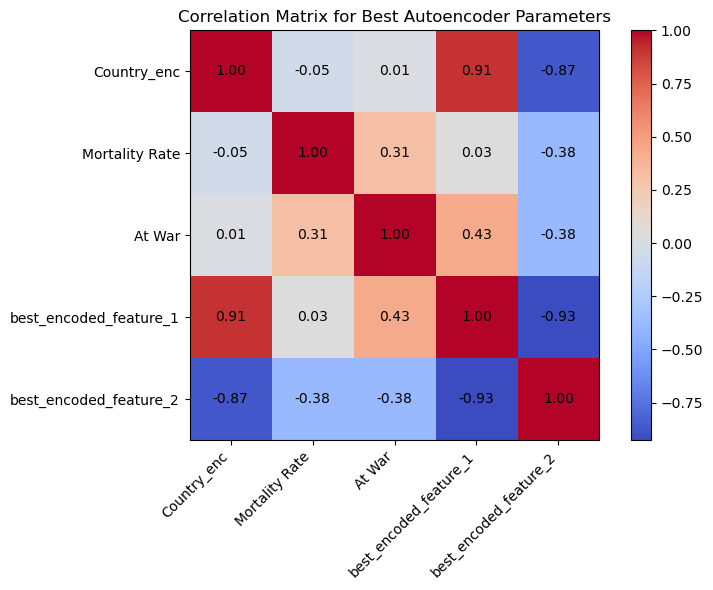

In [ ]:
from tensorflow.keras.models import Model

# Get the best estimator's model from grid search
best_model = grid_result.best_estimator_.model_

# Create an encoder model that outputs the bottleneck layer
encoder_best = Model(inputs=best_model.input, outputs=best_model.layers[1].output)

# Predict the latent features using the best autoencoder
encoded_features_best = encoder_best.predict(data_scaled)
n_features = encoded_features_best.shape[1]
column_names = [f'best_encoded_feature_{i+1}' for i in range(n_features)]
encoded_df_best = pd.DataFrame(encoded_features_best, columns=column_names)

# Add the new features to a copy of the original DataFrame for correlation analysis
df_best = df.copy()
df_best[column_names] = encoded_df_best

# Create correlation matrix using original features and the new latent features
cols = ['Country_enc', 'Mortality Rate', 'At War', 'best_encoded_feature_1', 'best_encoded_feature_2']
corr_matrix_best = df_best[cols].corr()

# Plot the correlation matrix heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix_best, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(len(corr_matrix_best.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix_best.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix_best.index)

# Annotate each cell with the correlation value
for i in range(corr_matrix_best.shape[0]):
    for j in range(corr_matrix_best.shape[1]):
        ax.text(j, i, f"{corr_matrix_best.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix for Best Autoencoder Parameters")
plt.tight_layout()
plt.show()

Summary statistics for best_encoded_feature_1:
count    5625.000000
mean        0.087859
std         0.034634
min         0.027834
25%         0.059372
50%         0.085712
75%         0.114388
max         0.174560
Name: best_encoded_feature_1, dtype: float64


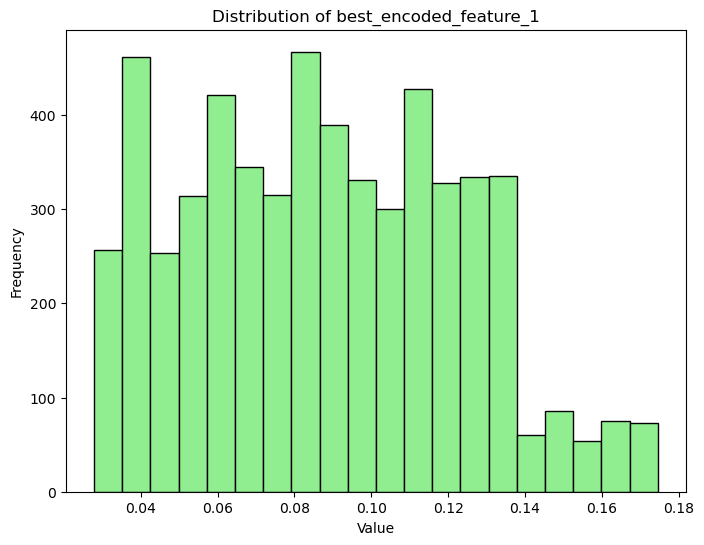


Correlation matrix including best_encoded_feature_1:
                        Country_enc  Mortality Rate    At War  \
Country_enc                1.000000       -0.047918  0.010383   
Mortality Rate            -0.047918        1.000000  0.310019   
At War                     0.010383        0.310019  1.000000   
best_encoded_feature_1     0.906023        0.031250  0.428556   

                        best_encoded_feature_1  
Country_enc                           0.906023  
Mortality Rate                        0.031250  
At War                                0.428556  
best_encoded_feature_1                1.000000  


In [ ]:
# Explanation:
# "best_encoded_feature_1" is one of the latent (encoded) features obtained from the autoencoder
# after optimizing its parameters by grid search. This feature represents a learned, compressed
# representation of the original data. Examining its summary statistics, distribution, and correlations
# with other key features can help in understanding what aspect of the data it captures.

# Print summary statistics for best_encoded_feature_1
print("Summary statistics for best_encoded_feature_1:")
print(df_best['best_encoded_feature_1'].describe())

# Plot histogram of best_encoded_feature_1
plt.figure(figsize=(8, 6))
plt.hist(df_best['best_encoded_feature_1'], bins=20, color='lightgreen', edgecolor='black')
plt.title("Distribution of best_encoded_feature_1")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Compute and display correlation of best_encoded_feature_1 with key features
key_features = ['Country_enc', 'Mortality Rate', 'At War', 'best_encoded_feature_1']
corr_be1 = df_best[key_features].corr()
print("\nCorrelation matrix including best_encoded_feature_1:")
print(corr_be1)

Summary statistics for best_encoded_feature_2:
count    5625.000000
mean       -0.105562
std         0.040523
min        -0.304500
25%        -0.133220
50%        -0.106084
75%        -0.073199
max        -0.030137
Name: best_encoded_feature_2, dtype: float64


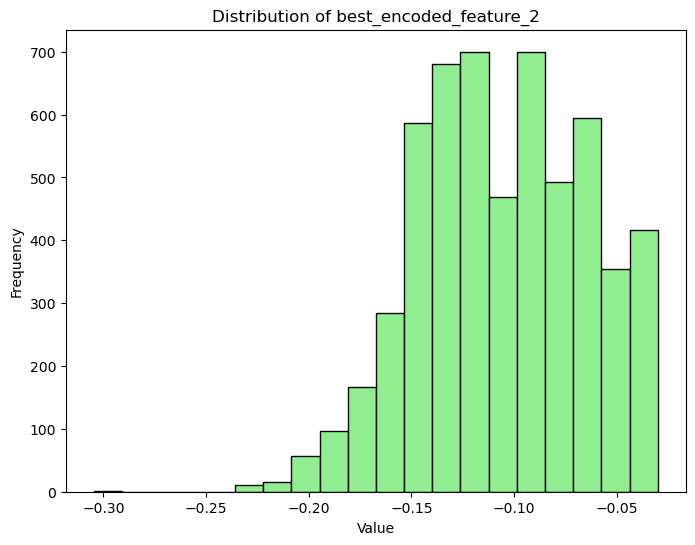


Correlation matrix including best_encoded_feature_2:
                        Country_enc  Mortality Rate    At War  \
Country_enc                1.000000       -0.047918  0.010383   
Mortality Rate            -0.047918        1.000000  0.310019   
At War                     0.010383        0.310019  1.000000   
best_encoded_feature_2    -0.870074       -0.379185 -0.383120   

                        best_encoded_feature_2  
Country_enc                          -0.870074  
Mortality Rate                       -0.379185  
At War                               -0.383120  
best_encoded_feature_2                1.000000  


In [ ]:
# Explanation:
# "best_encoded_feature_2" is one of the latent (encoded) features obtained from the autoencoder
# after optimizing its parameters by grid search. This feature represents a learned, compressed
# representation of the original data. Examining its summary statistics, distribution, and correlations
# with other key features can help in understanding what aspect of the data it captures.

# Print summary statistics for best_encoded_feature_2
print("Summary statistics for best_encoded_feature_2:")
print(df_best['best_encoded_feature_2'].describe())

# Plot histogram of best_encoded_feature_2
plt.figure(figsize=(8, 6))
plt.hist(df_best['best_encoded_feature_2'], bins=20, color='lightgreen', edgecolor='black')
plt.title("Distribution of best_encoded_feature_2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Compute and display correlation of best_encoded_feature_2 with key features
key_features = ['Country_enc', 'Mortality Rate', 'At War', 'best_encoded_feature_2']
corr_be1 = df_best[key_features].corr()
print("\nCorrelation matrix including best_encoded_feature_2:")
print(corr_be1)

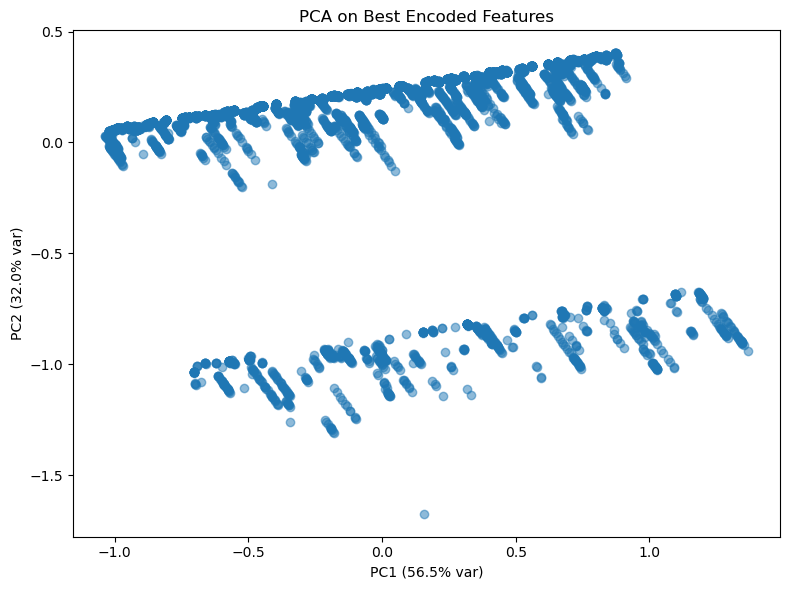

In [ ]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on best encoded features (already predicted in encoded_features_best)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_features_best)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA on Best Encoded Features')
plt.tight_layout()
plt.show()

Look at the Encoded Freatures Mutual Information (MI): Mutual information (MI) between latent features and a target (or another feature) tells you how much information one variable provides about another — in this case, how informative your latent features are about the labels or original variables.

MI = 0: The latent feature gives no information about the target (they’re independent).

Higher MI (> 0): The latent feature is more informative — it captures some structure related to the target variable.

Maximum MI (bounded by entropy of the target): Implies perfect knowledge of the target from that latent feature.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define encoded_data using the latent features generated previously (from encoded_df)
encoded_data = encoded_df.values

# Ensure 'At War_enc' column exists in df
if 'At War_enc' not in df.columns:
	df['At War_enc'] = df['At War'].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'at war', 'true'] else 0)

# Define y_data as the binary target (using the 'At War_enc' column from df)
y_data = df['At War_enc'].values

mi = mutual_info_classif(encoded_data, y_data)
print("Mutual Information:", mi)


Mutual Information: [0 0]


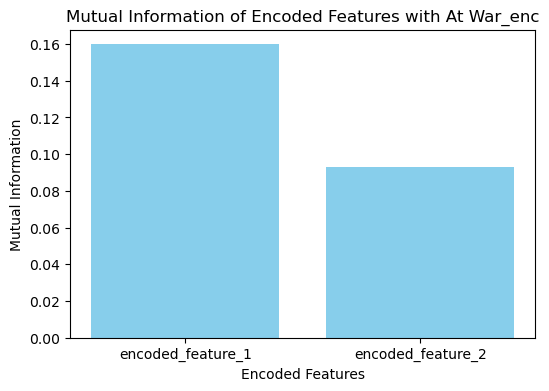

In [ ]:
# Visualize mutual information as a bar chart
features = ['encoded_feature_1', 'encoded_feature_2']
plt.figure(figsize=(6, 4))
plt.bar(features, mi, color='skyblue')
plt.xlabel('Encoded Features')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of Encoded Features with At War_enc')
plt.show()

A look at mutual information between latent and original input features.

High values show strong mutual information between a specific encoded feature and an original feature — suggesting that the autoencoder has learned to preserve that specific information.

Low values (≈ 0) indicate little to no information transfer for that pair.

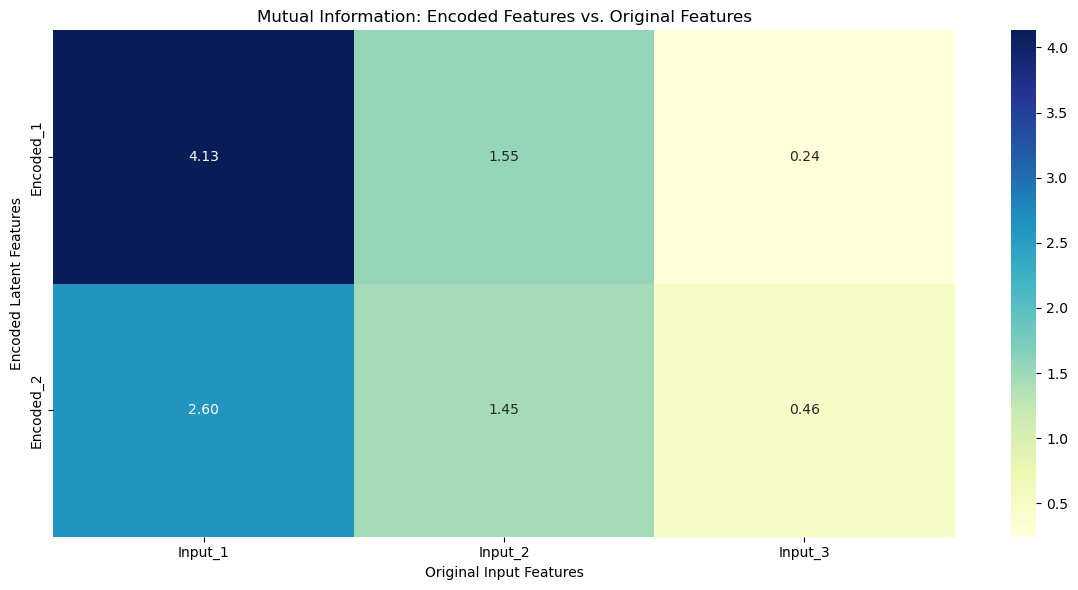

In [ ]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
X_original = data  # Define X_original using the original numeric data (already defined in a previous cell)

# encoded_data: (n_samples, n_latent_features)
# X_original: (n_samples, n_input_features)

# Make sure X_original is numeric
if isinstance(X_original, pd.DataFrame):
    original_features = X_original.columns
else:
    original_features = [f"Input_{i+1}" for i in range(X_original.shape[1])]

encoded_feature_names = [f"Encoded_{i+1}" for i in range(encoded_data.shape[1])]

# Compute mutual information matrix
mi_matrix = np.zeros((encoded_data.shape[1], X_original.shape[1]))

for i in range(encoded_data.shape[1]):
    mi_matrix[i, :] = mutual_info_regression(X_original, encoded_data[:, i])

    # Create a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=encoded_feature_names, columns=original_features)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mi_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Mutual Information: Encoded Features vs. Original Features')
plt.xlabel('Original Input Features')
plt.ylabel('Encoded Latent Features')
plt.tight_layout()
plt.show()
